# MLP for Sine Wave Prediction
## MSE23185 - Tran Trong Hieu
## Excercise 5: Build a 3-layer MLP for Sine Wave Prediction from my configuration:
- Using He weight initialization
- Using activation function in hidden layers: ELU
- Using number of neurons in each layer: 500
- Using loss function : MSE
- Optimizer: RMSProb


Epoch 0, Loss: 110.62110724110227
Epoch 1000, Loss: 0.1553084439368322
Epoch 2000, Loss: 0.03619814986449026
Epoch 3000, Loss: 0.06724751029509636
Epoch 4000, Loss: 0.012634302088056264
Epoch 5000, Loss: 0.020510775929907563
Epoch 6000, Loss: 0.05059548826050797
Epoch 7000, Loss: 0.012897072321799223
Epoch 8000, Loss: 0.027525642923630196
Epoch 9000, Loss: 0.11857596984022317


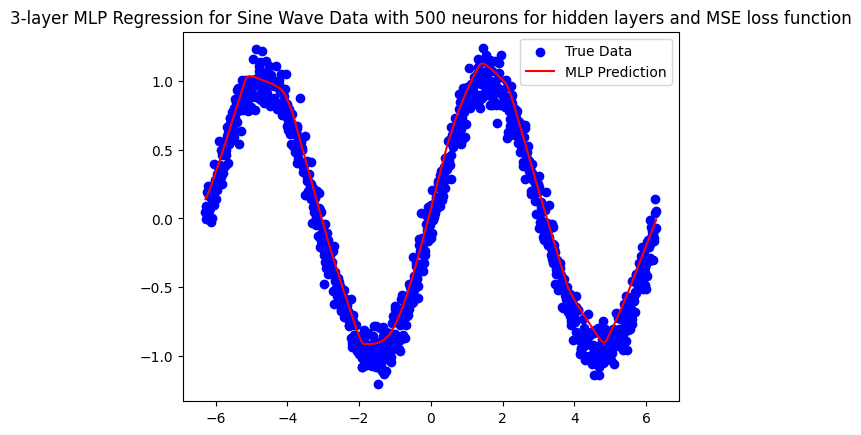

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt

# Generate sine wave data
np.random.seed(42)
X = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(-1, 1) # Input feature
y = np.sin(X) + 0.1 * np.random.randn(*X.shape) # Target with some noise

# Define the ELU activation function
def elu(x, alpha = 1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# Define the derivative of the ELU function
def elu_derivative(x, alpha = 1.0):
    return np.where(x > 0, 1, elu(x, alpha) + alpha)

# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivative of MSE with respect to prediction
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Mean Absolute Error loss function
def mae_loss(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Derivative of MAE with respect to prediction
def mae_loss_derivative(y_true, y_pred):
    return np.where(y_pred > y_true, 1, -1) / y_true.size

# Initialize weights and biases
def initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers = 2):
    parameters = {}
    parameters['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
    parameters['b1'] = np.random.randn(1, hidden_size)

    for i in range(2, num_hidden_layers + 1):
        parameters[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
        parameters[f'b{i}'] = np.random.randn(1, hidden_size)

    parameters[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
    parameters[f'b{num_hidden_layers + 1}'] = np.random.randn(1, output_size)

    return parameters

# Forward pass
def forward(X, parameters, num_hidden_layers = 2):
    cache = {}

    A = X

    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, parameters[f'W{i}']) + parameters[f'b{i}']
        A = elu(Z)
        cache[f'Z{i}'] = Z
        cache[f'A{i}'] = A

    # Output layer (linear function)
    Z_output = np.dot(A, parameters[f'W{num_hidden_layers + 1}']) + parameters[f'b{num_hidden_layers + 1}']
    cache[f'Z{num_hidden_layers + 1}'] = Z_output

    return Z_output, cache

# Backward pass with RMSProp
def backward(X, y, parameters, cache, squared_gradients, num_hidden_layers = 2, learning_rate = 0.001, beta = 0.9, epsilon = 1e-8, loss_type = 'MSE'):
    m = y.size
    grads = {}

    if loss_type == 'MAE':
        dZ_output = mae_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}'])
    else:
        dZ_output = mse_loss_derivative(y, cache[f'Z{num_hidden_layers + 1}'])

    grads[f'dW{num_hidden_layers + 1}'] = np.dot(cache[f'A{num_hidden_layers}'].T, dZ_output) / m
    grads[f'db{num_hidden_layers + 1}'] = np.sum(dZ_output, axis = 0, keepdims = True) / m

    dA_prev = np.dot(dZ_output, parameters[f'W{num_hidden_layers + 1}'].T)

    for i in range(num_hidden_layers, 0, -1):
        dZ = dA_prev * elu_derivative(cache[f'Z{i}'])
        grads[f'dW{i}'] = np.dot((X if i == 1 else cache[f'A{i - 1}']).T, dZ) / m
        grads[f'db{i}'] = np.sum(dZ, axis = 0, keepdims = True) / m
        if i > 1:
            dA_prev = np.dot(dZ, parameters[f'W{i}'].T)

    for i in range(1, num_hidden_layers + 2):
        squared_gradients[f'W{i}'] = beta * squared_gradients[f'W{i}'] + (1 - beta) * grads[f'dW{i}'] ** 2
        squared_gradients[f'b{i}'] = beta * squared_gradients[f'b{i}'] + (1 - beta) * grads[f'db{i}'] ** 2

        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}'] / (np.sqrt(squared_gradients[f'W{i}']) + epsilon)
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}'] / (np.sqrt(squared_gradients[f'b{i}']) + epsilon)

    return parameters, squared_gradients

# Training loop
def train(X, y, hidden_size = 100, epochs = 5000, learning_rate = 0.001, beta = 0.9, loss_type = 'MSE'):
    input_size = X.shape[1]
    output_size = 1 # We want 1 output (regression)
    num_hidden_layers = 2

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size, output_size, num_hidden_layers)
    squared_gradients = {k: np.zeros_like(v) for k, v in parameters.items()}

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        y_pred, cache = forward(X, parameters, num_hidden_layers)

        # Compute loss
        if loss_type == 'MAE':
            loss = mae_loss(y, y_pred)
        else:
            loss = mse_loss(y, y_pred)

        # Backward pass and update parameters
        parameters, squared_gradients = backward(X, y, parameters, cache, squared_gradients, num_hidden_layers, learning_rate, beta, loss_type = loss_type)

        # Print loss every 100 epochs
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return parameters

# Prediction
def predict(X, parameters, num_hidden_layers = 2):
    y_pred, _ = forward(X, parameters, num_hidden_layers)
    return y_pred

# Train the MLP
parameters = train(X, y, hidden_size = 500, epochs = 10000, learning_rate = 0.001, loss_type = 'MSE')

# Predict on the training data
y_pred = predict(X, parameters)

# Plot the results
plt.scatter(X, y, label='True Data', color='blue')
plt.plot(X, y_pred, label='MLP Prediction', color='red')
plt.legend()
plt.title('3-layer MLP Regression for Sine Wave Data with 500 neurons for hidden layers and MSE loss function')
plt.show()

## Nhận xét:
- Ở mô hình này là tổng hợp những điều tốt nhất của các mô hình trong 4 bài trước và nâng số neuron lên 500. Kết quả cho thấy mô hình dự đoán khá tốt nhưng vẫn chưa sát với tập dữ liệu ở đoạn uốn cong của sin wave.